Voglio modellare un solo pullman con 10 posti e clienti che arrivano ogni 1 tu.

1) Il bus è in attesa e appena salgono 10 cienti parte.
2) impiega 12 tu ad andare/scaricare e tornare.
3) Carica altri 10 clienti e riparte.

In [1]:
import simpy

# CODICE FUNZIONANTE 

Perchè funziona: Prima facevo la get subito all'inizio del processo navetta (bus), ma questo permetteva agli altri bus di mettersi dentro lo store.

In questo caso la get viene fatta solo quando il bus è pieno e l'autobus si sveglia ogni poco per controllare che ci siano viaggiatori pronti a salire, quando è pieno parte e libera lo store.

In [2]:
import simpy
import random


class Navetta:
    def __init__(self, env, name, capacita):
        self.env = env
        self.name = name
        self.capacita = capacita
        self.passengers_on_board = 0
        self.in_viaggio = False
        # Questo Store interno alla navetta serve per i passeggeri che DEVONO salire su QUESTA navetta
        self.coda_imbarco_interna = simpy.Store(env) 

class Cliente:
    def __init__(self, env, name, time_arrival):
        self.env = env
        self.name = name
        self.time_arrival = time_arrival
        self.time_boarded = None  # Tempo in cui il cliente è salito sulla navetta
        self.time_departure = None  # Tempo in cui il cliente ha finito il suo viaggio
        self.attesa = 0 # Tempo di attesa per salire su una navetta
        
    
def generatore_clienti(env, passenger_queue,history, tempo_massimo_simulazione):
    i = 0
    while len(history) < MAX_PASSENGERS:  # Limita il numero di clienti per evitare loop infiniti
        now = int(env.now)
        if now < HOT_HOUR:
            new_lambda = BASE_LAMBDA + PEAK_FACTOR * (now / HOT_HOUR)**2
        else:
            new_lambda = BASE_LAMBDA + PEAK_FACTOR
        yield env.timeout(random.expovariate(new_lambda))
        i += 1
        print(f'{env.now:.2f}: Cliente {i} arriva e si mette in coda generale.')

        # I clienti si mettono in una coda generale, non cercano un bus specifico subito
        passenger = Cliente(env, i, env.now)
        history.append(passenger)  # Aggiungi il cliente alla storia per il report finale

        passenger_queue.put(passenger)
        if env.now > tempo_massimo_simulazione: 
            break

def client(env, passenger, navetta_destinazione):
    # Il cliente ora sa quale navetta deve salire e aspetta di essere imbarcato
    print(f'{env.now:.2f}: passenger {passenger.name} sta salendo sulla {navetta_destinazione.name}.')
    yield env.timeout(0)
    print(f'{env.now:.2f}: passenger {passenger.name} è salito sulla {navetta_destinazione.name}.')
    # L'azione del cliente finisce qui per questa simulazione, ma potrebbe includere il viaggio e lo sbarco

def processo_navetta(env, navetta_obj, bus_attivi_per_imbarco, passenger_queue):
    # Ogni navetta inizia il suo ciclo
    while True:
        # La navetta si mette in coda per essere la prossima ad attivarsi per l'imbarco
        yield bus_attivi_per_imbarco.put(navetta_obj)
        print(f'\n{env.now:.2f}: {navetta_obj.name} è alla fermata e attiva per l\'imbarco.')
        
        navetta_obj.passengers_on_board = 0
        current_passengers = []
        time_idle = env.now  # Tempo in cui la navetta è in attesa di passeggeri
        # La navetta ora attende di riempirsi dalla coda generale
        while navetta_obj.passengers_on_board < navetta_obj.capacita and (not SMART_DRIVER or (env.now - time_idle <= SMART_TIME and navetta_obj.passengers_on_board <= navetta_obj.capacita* SMART_PERCENTAGE)):
            # Tenta di prendere un passeggero dalla coda generale
            # try:
                # Aspetta che un passeggero sia disponibile nella coda generale
            passenger = yield passenger_queue.get()
            current_passengers.append(passenger)
            # Una volta che un passeggero è disponibile, lo "imbarca" su QUESTA navetta
            env.process(client(env, passenger, navetta_obj))
            passenger.time_boarded = env.now  # Registra il tempo in cui il cliente è salito sulla navetta
            navetta_obj.passengers_on_board += 1
                
            print(f'{env.now:.2f}: {navetta_obj.name}: Imbarcato passeggero {passenger.name}. Totale: {navetta_obj.passengers_on_board}/{navetta_obj.capacita}.')
                
            # except simpy.Empty as e:
            #     # Se non ci sono passeggeri, la navetta aspetta che ne arrivino
            #     print(f'{env.now:.2f}: {navetta_obj.name} aspetta passeggeri...')
            #     yield env.timeout(1) # Attende un po' e riprova

        print(f'{env.now:.2f}: {navetta_obj.name} è PIENA ({navetta_obj.passengers_on_board} passeggeri). Parte ora!')
        
        for passenger in current_passengers:
            passenger.time_departure = env.now

        # Una volta piena, la navetta "si rimuove" dallo store dei bus attivi per l'imbarco
        # Questo permette alla prossima navetta in coda di attivarsi.
        yield bus_attivi_per_imbarco.get() # La navetta si rimuove dallo stato "attiva per imbarco"

        # Simula il viaggio
        navetta_obj.in_viaggio = True
        yield env.timeout(TRAVEL_TIME)
        navetta_obj.in_viaggio = False
        
        print(f'{env.now:.2f}: {navetta_obj.name} è arrivata a destinazione e scarica i passeggeri. Ora torna vuota.')
        navetta_obj.passengers_on_board = 0 # Scarica i passeggeri
        # La navetta è ora di nuovo disponibile per il prossimo ciclo (tornerà in coda per l'imbarco)

In [3]:
class Configuration:
    def __init__(self, num_navette, smart_driver, smart_time, smart_percentage):
        self.num_navette = num_navette
        self.smart_driver = smart_driver
        self.smart_time = smart_time
        self.smart_percentage = smart_percentage
        self.history = []  # Lista per tenere traccia dei passeggeri e dei loro tempi di imbarco e sbarco


In [4]:
CAPACITA_NAVETTA = 25  # Numero di passeggeri che una navetta può trasportare
TRAVEL_TIME = 10    # Tempo di viaggio in minuti
MAX_PASSENGERS = 500  # Numero massimo di passeggeri che possono essere generati
BASE_LAMBDA = 0.1 # Regulates the average arrival rate of passengers (1/lambda is the average time between arrivals)
SIMULATION_TIME = 300
HOT_HOUR = 50  # L'ora X, ad es. il 120° minuto
PEAK_FACTOR = 5 # Fattore di aumento del tasso di arrivo durante l'ora di punta
SMART_PERCENTAGE = 0.5  # Soglia oltre la quale il driver può decidere di partire anche se non è pieno
SMART_TIME = 10  # Tempo massimo che una navetta può aspettare prima di partire anche se non è piena

SMART_DRIVER = True
NUM_NAVETTE_TOTALI = 4 # Numero totale di navette disponibili

smart_driver = [False]
num_navette = [1,2,3,4,5,6,7,8]
smart_time = [5,10,20,25]
smart_percentage = [0.5, 0.7, 0.8]
configurations = []

# Esegui la simulazione per diverse configurazioni di navette e smart driver
for NUM_NAVETTE_TOTALI in num_navette:
    for SMART_DRIVER in smart_driver:
        for SMART_PERCENTAGE in smart_percentage:
            for SMART_TIME in smart_time:
                        # Crea una nuova configurazione per ogni combinazione di parametri
                configuration = Configuration(NUM_NAVETTE_TOTALI, SMART_DRIVER, SMART_TIME, SMART_PERCENTAGE)
                for i in range(1):  # Esegui 100 simulazioni per ogni configurazione

                    env = simpy.Environment()

                    # Questa è la coda dove i passeggeri si accodano appena arrivano
                    passenger_queue = simpy.Store(env) 

                    # Questo Store gestisce quale navetta è ATTIVA per l'imbarco in un dato momento
                    # Ha capacità 1, quindi solo UNA navetta può essere messa qui alla volta.
                    # Le navette "competono" per essere qui.
                    bus_attivi_per_imbarco = simpy.Store(env, capacity=1)

                    # Avvia i processi delle navette
                    for i in range(NUM_NAVETTE_TOTALI):
                        navetta_obj = Navetta(env, f'Bus_{i+1}', CAPACITA_NAVETTA)
                        env.process(processo_navetta(env, navetta_obj, bus_attivi_per_imbarco, passenger_queue))

                    # Avvia il generatore di clienti
                    history = []  # Lista per tenere traccia dei clienti per il report finale
                    env.process(generatore_clienti(env, passenger_queue, history, SIMULATION_TIME))

                    # Esegui la simulazione
                    print(f'--- Simulazione avviata per {SIMULATION_TIME} minuti ---')
                    env.run(until=SIMULATION_TIME)
                    print('--- Simulazione terminata ---')

                    configuration.history.append(history)  # Salva la storia dei passeggeri nella configurazione
                configurations.append(configuration)

--- Simulazione avviata per 300 minuti ---

0.00: Bus_1 è alla fermata e attiva per l'imbarco.
3.75: Cliente 1 arriva e si mette in coda generale.
3.75: Bus_1: Imbarcato passeggero 1. Totale: 1/25.
3.75: passenger 1 sta salendo sulla Bus_1.
3.75: passenger 1 è salito sulla Bus_1.
20.70: Cliente 2 arriva e si mette in coda generale.
20.70: Bus_1: Imbarcato passeggero 2. Totale: 2/25.
20.70: passenger 2 sta salendo sulla Bus_1.
20.70: passenger 2 è salito sulla Bus_1.
22.02: Cliente 3 arriva e si mette in coda generale.
22.02: Bus_1: Imbarcato passeggero 3. Totale: 3/25.
22.02: passenger 3 sta salendo sulla Bus_1.
22.02: passenger 3 è salito sulla Bus_1.
22.12: Cliente 4 arriva e si mette in coda generale.
22.12: Bus_1: Imbarcato passeggero 4. Totale: 4/25.
22.12: passenger 4 sta salendo sulla Bus_1.
22.12: passenger 4 è salito sulla Bus_1.
22.84: Cliente 5 arriva e si mette in coda generale.
22.84: Bus_1: Imbarcato passeggero 5. Totale: 5/25.
22.84: passenger 5 sta salendo sulla Bus_1.


KeyboardInterrupt: 

(array([ 3.,  5.,  3.,  0.,  1.,  3.,  6.,  3.,  3.,  4.,  3.,  6.,  6.,
         6.,  9., 10.,  8.,  8., 10.,  8.,  8., 13.,  6., 11., 18., 13.,
         7.,  9., 18.,  9., 11., 18., 13., 16., 16., 15., 19., 19.,  9.,
        11., 11., 15., 15., 21.,  8., 11.,  9., 16., 12., 18.]),
 array([  2.80776931,   4.9204031 ,   7.03303689,   9.14567067,
         11.25830446,  13.37093825,  15.48357203,  17.59620582,
         19.70883961,  21.82147339,  23.93410718,  26.04674097,
         28.15937475,  30.27200854,  32.38464233,  34.49727611,
         36.6099099 ,  38.72254369,  40.83517747,  42.94781126,
         45.06044505,  47.17307883,  49.28571262,  51.39834641,
         53.51098019,  55.62361398,  57.73624777,  59.84888155,
         61.96151534,  64.07414913,  66.18678291,  68.2994167 ,
         70.41205049,  72.52468427,  74.63731806,  76.74995185,
         78.86258563,  80.97521942,  83.08785321,  85.20048699,
         87.31312078,  89.42575457,  91.53838835,  93.65102214,
         95.

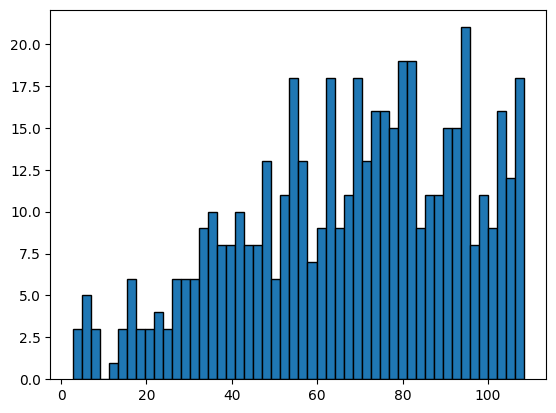

In [ ]:
import matplotlib.pyplot as plt

# Plot the number of passengers boarded over time
times = [p.time_arrival for p in history]
plt.hist(times, bins=50, edgecolor='black')

(array([32., 20., 20., 19., 28., 26., 28., 46., 24., 23., 26., 24., 24.,
        19., 28., 17., 18., 14., 10.,  8.,  6.,  3.,  3.,  0.,  1.,  0.,
         1.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  2.,  0.,  1.,  3.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.]),
 array([10.        , 10.2932892 , 10.5865784 , 10.87986761, 11.17315681,
        11.46644601, 11.75973521, 12.05302441, 12.34631362, 12.63960282,
        12.93289202, 13.22618122, 13.51947042, 13.81275962, 14.10604883,
        14.39933803, 14.69262723, 14.98591643, 15.27920563, 15.57249484,
        15.86578404, 16.15907324, 16.45236244, 16.74565164, 17.03894085,
        17.33223005, 17.62551925, 17.91880845, 18.21209765, 18.50538686,
        18.79867606, 19.09196526, 19.38525446, 19.67854366, 19.97183287,
        20.26512207, 20.55841127, 20.85170047, 21.14498967, 21.43827887,
        21.73156808, 22.02485728, 22.31814648, 22.61143568, 22.90472488,
        23.19801409, 23.49130329, 23.78459249, 24.07788169,

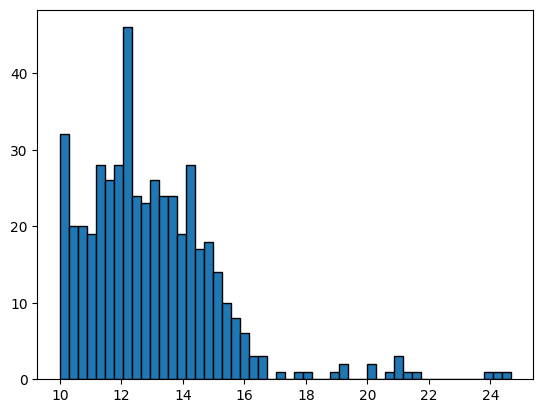

In [ ]:
waiting_times = [(p.time_departure + TRAVEL_TIME ) - p.time_arrival for p in history if p.time_departure is not None]
plt.hist(waiting_times, bins=50, edgecolor='black')

In [ ]:
average_waiting_times = []
for config in configurations:
    print(f'Configurazione: {config.num_navette} navette, Smart Driver: {config.smart_driver}, Smart Time: {config.smart_time}, Smart Percentage: {config.smart_percentage}')
    total_passengers = sum(len(history) for history in config.history)
    print(f'Totale passeggeri imbarcati: {total_passengers}')
    average_waiting_times.append(sum(p.time_departure - p.time_arrival for history in config.history for p in history if p.time_departure is not None) / total_passengers)
    print(f'Tempo medio di attesa per i passeggeri: {average_waiting_times[-1]:.2f} minuti')

Configurazione: 3 navette, Smart Driver: True, Smart Time: 5, Smart Percentage: 0.5
Totale passeggeri imbarcati: 500
Tempo medio di attesa per i passeggeri: 16.32 minuti
Configurazione: 3 navette, Smart Driver: True, Smart Time: 10, Smart Percentage: 0.5
Totale passeggeri imbarcati: 500
Tempo medio di attesa per i passeggeri: 16.15 minuti
Configurazione: 3 navette, Smart Driver: True, Smart Time: 20, Smart Percentage: 0.5
Totale passeggeri imbarcati: 500
Tempo medio di attesa per i passeggeri: 15.38 minuti
Configurazione: 3 navette, Smart Driver: True, Smart Time: 25, Smart Percentage: 0.5
Totale passeggeri imbarcati: 500
Tempo medio di attesa per i passeggeri: 15.76 minuti
Configurazione: 3 navette, Smart Driver: True, Smart Time: 5, Smart Percentage: 0.7
Totale passeggeri imbarcati: 500
Tempo medio di attesa per i passeggeri: 4.62 minuti
Configurazione: 3 navette, Smart Driver: True, Smart Time: 10, Smart Percentage: 0.7
Totale passeggeri imbarcati: 500
Tempo medio di attesa per i pa

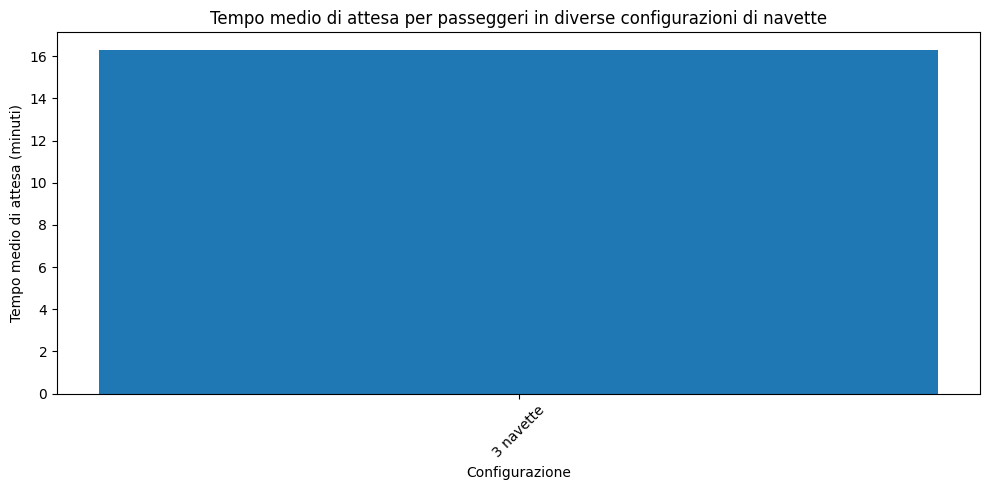

In [ ]:
# Plot the average waiting times for each configuration
plt.figure(figsize=(10, 5))
plt.bar([f'{config.num_navette} navette' for config in configurations], average_waiting_times)
plt.xlabel('Configurazione')
plt.ylabel('Tempo medio di attesa (minuti)')
plt.title('Tempo medio di attesa per passeggeri in diverse configurazioni di navette')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
for config in configurations:
    print(f'Configuration: {config.num_navette} navette, Smart Driver: {config.smart_driver}')
    print(f'Total passengers boarded: {len(config.history)}')
    waiting_times = [(p.time_departure + TRAVEL_TIME) - p.time_arrival for p in config.history[] if p.time_departure is not None]
    print(f'Average waiting time: {sum(waiting_times) / len(waiting_times):.2f} minutes')
    print(f'maximum waiting time: {max(waiting_times):.2f} minutes')
    print('---')

SyntaxError: invalid syntax (2513167112.py, line 4)